# This notebook is for implementing and experimenting with IF ML algorithm on SAAS Data:

In [3]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline


## Importing Data

In [4]:
from config import *
#Paths defined in python Config file

#Saas Paths
#raw_saas_path  
#proc_saas_path  

#RabbitMQ paths
#raw_evts_path  
#proc_evts_path  

#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

df = load_data(proc_saas_path)


df.head()

,user_id,event_type,cl0,cl1,cl2,cl3,cl4,count
timestamp,,,,,,,,
2019-05-22 11:25:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 11:28:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,90
2019-05-22 20:02:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 20:02:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,6
2019-05-28 06:39:00,404132,PROFILE_CREATED,10260,192565,7035,323209,3444,1


## Outlier detection : Isolation Forest

In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np


In [4]:
metrics_df=pd.pivot_table(df,values='count',index=['timestamp' ],columns='event_type')
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df

event_type,timestamp,PROFILE_CREATED,PROFILE_DELETED,PROFILE_UPDATED,USER_CREATED,USER_DELETED,USER_UPDATED
0,2019-05-22 11:25:00,0.0,0.0,2.0,0.0,0.0,0.0
1,2019-05-22 11:28:00,0.0,0.0,90.0,0.0,0.0,0.0
2,2019-05-22 20:02:00,0.0,0.0,4.0,0.0,0.0,0.0
3,2019-05-28 06:39:00,1.0,0.0,0.0,0.0,0.0,1.0
4,2019-06-03 10:03:00,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
474,2020-03-20 22:47:00,0.0,0.0,15.0,0.0,0.0,0.0
475,2020-03-22 22:02:00,0.0,0.0,8.0,0.0,0.0,0.0
476,2020-03-23 22:47:00,0.0,0.0,10.0,0.0,0.0,0.0
477,2020-03-24 22:47:00,0.0,0.0,9.0,0.0,0.0,0.0


In [22]:
#Number of Fraud Cases and Valid cases
#IS 70 A GOOD THRESHOLD NUMBER? THIS NEEDS TO BE CHECKED
anom = df[df['count']>=70]
valid = df[df['count']<70]

outlier_fraction = len(anom)/(len(valid))
outlier_fraction


0.05446293494704992

In [30]:
print('specify the 6 metrics column names to be modelled')
print(metrics_df.columns[2:7])
to_model_columns=metrics_df.columns[2:7]#specify the 6 metrics column names to be modelled

#n_estimators :nb of isolation trees
#n_estimators=100,

#max_samples: nb of samples
#contamination: rate of anomalies ,usually anom_counts/total data or 0.01
    #contamination = outlier_fraction
    #Or it can be contam=randrange_float(0.0, 0.5, 0.05)
#max_features :nb of features to draw from X to train each base estimator
#  max_features=1.0
#contam=0.01

clf=IsolationForest( max_samples='auto', contamination =outlier_fraction, \
                    random_state=42, verbose=0)#verbose for logging detailed output


clf.fit(metrics_df[to_model_columns])

# Predict if a particular sample is an outlier using all features for higher dimensional data set.
# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred


#print(metrics_df['anomaly'])
print(metrics_df['anomaly'].value_counts())

outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous


specify the 6 metrics column names to be modelled
Index(['PROFILE_DELETED', 'PROFILE_UPDATED', 'USER_CREATED', 'USER_DELETED',
       'USER_UPDATED'],
      dtype='object', name='event_type')
 1    452
-1     27
Name: anomaly, dtype: int64


    Number of outliers indicated by -1
    Now here we have 6 event types on which we have classified anomalies based on isolation forest.
    We will try to visualize the results and check if the classification makes sense

    next we continue by Normalizing and fiting the metrics to a PCA to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.


*PCA*
       
       PCA is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated).
    
    From our Saas data-set we see that it has 6 features so far, so let’s reduce it to only 3 principal 
    features and then we can visualize the scatter plot of these new independent variables.

    Before applying PCA, we scale our data such that each feature has unit variance. This is necessary because 
    fitting algorithms highly depend on the scaling of the features. Here we use the StandardScalermodule for
    scaling the features individually. StandardScalersubtracts the mean from each features and then scale to 
    unit variance.



*standardization*

    for a matrix X where each row/line is a sample/observation and each column is a variable/feature 
    (this is the expected input for any sklearn ML function by the way -- X.shape should
    be [number_of_samples, number_of_features]).

    Core of method: 
    The main idea is to normalize/standardize : μ = 0 and σ = 1 your features/variables/columns of X, individually, before applying any machine learning model.

    StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY (!!!)
    so that each column/feature/variable will have μ = 0 and σ = 1.

    why standardization ?
    Standardization of a dataset is a common requirement for many machine learning estimators: they might behave
    badly if the individual features do not more or less look like standard normally distributed data 
    (e.g. Gaussian with 0 mean and unit variance). 
    For instance many elements used in the objective function of a learning algorithm 
    (such as the RBF kernel of SVM or the L1 and L2 regularizers of linear models) assume that
    all features are centered around 0 and have variance in the same order. –

    So, Standardization leads to 
    a) more stable 
    b) less influenced by the range of variables
    c) faster fitting 
    d) more stable performance 

X
[[-0.16080008 -0.39099756 -0.25848626 -0.102706   -0.54943935]
 [-0.16080008  2.83810301 -0.25848626 -0.102706   -0.54943935]
 [-0.16080008 -0.31760891 -0.25848626 -0.102706   -0.54943935]
 ...
 [-0.16080008 -0.09744297 -0.25848626 -0.102706   -0.54943935]
 [-0.16080008 -0.13413729 -0.25848626 -0.102706   -0.54943935]
 [-0.16080008 -0.46438621 -0.25848626 -0.102706    1.50132519]]
-----------------------------------
X_reduce
[[-0.11577618 -0.11540915  0.07430145]
 [-0.04559636 -2.33929011 -1.19105675]
 [-0.11418119 -0.1659519   0.04554331]
 ...
 [-0.1093962  -0.31758014 -0.04073112]
 [-0.1101937  -0.29230877 -0.02635205]
 [-0.36313021  1.39529341 -0.45560415]]
-----------------------------------


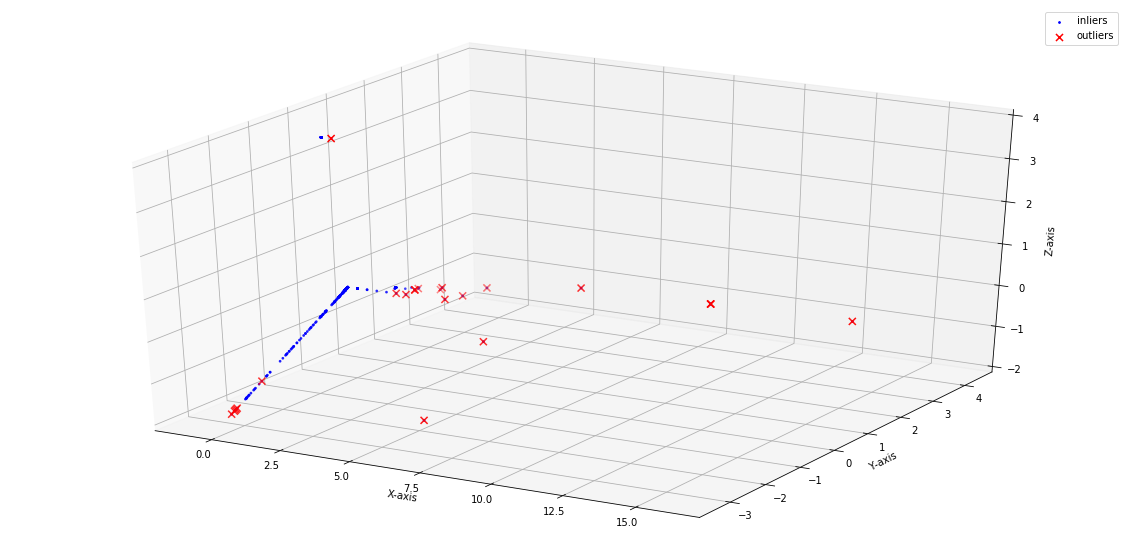

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Number of components to keepn here Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
print('X')
print(X)

print('-----------------------------------')
X_reduce = pca.fit_transform(X)
print('X_reduce')
print(X_reduce)

print('-----------------------------------')
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111, projection='3d')

ax.set_zlabel("x_3_dimensions")# Plot the compressed data points
#plot the inliers in blue ,aka  "interior" points of the distribution

x_vals = X_reduce[:, 0]
y_vals =  X_reduce[:, 1]
z_vals = X_reduce[:, 2]

# Plot the values
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.scatter(x_vals, y_vals, z_vals, s=3, lw=1, label="inliers",c="blue")

#Plot x's for the ground truth outliers in red
ax.scatter(X_reduce[outlier_index,0],
           X_reduce[outlier_index,1],
           X_reduce[outlier_index,2],
           s=50, marker="x",  #s for defining the marker size
           c="red",
           label="outliers")
ax.legend()
plt.show()

    Now as we see the 3D point the anomaly points are mostly wide from the cluster of normal points,


In [32]:
#the variance ratio of the principal components:
ex_variance=np.var(X_reduce,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio )

[0.41634339 0.31109831 0.2725583 ]


    we can see that the first 2 components contributes to 72% of the total variance.
    So it’s good enough to choose only 2 components. 
    Okay, now with these first 2 components, we can jump to one of the most important application of PCA, 
    which is data visualization. 
    Now, since the PCA components are orthogonal to each other and they are not correlated, we can expect to 
    see malignant and benign classes as distinct.

    Lets try plotting the same fed to a PCA reduced to 2 dimensions.

             0         1
0   -10.654596 -0.325431
1    77.344361 -0.452039
2    -8.654619 -0.328308
3   -12.659115 -0.335915
4   -12.659115 -0.335915
..         ...       ...
474   2.345250 -0.344134
475  -4.654667 -0.334063
476  -2.654690 -0.336941
477  -3.654679 -0.335502
478 -12.659115 -0.335915

[479 rows x 2 columns]
115.34391042559527
27.692308334040906


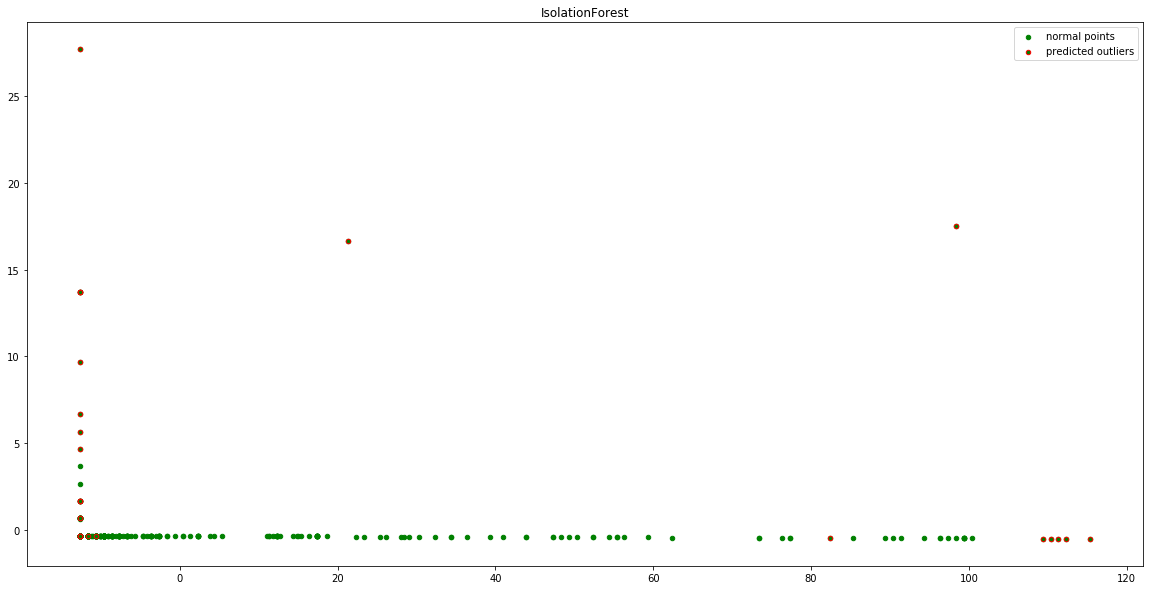

In [33]:
from sklearn.decomposition import PCA

pca = PCA(2) #dimension of two
#pca.fit(metrics_df[to_model_columns])    #fit the pivot data to 2-d PCA

#build a dataframe from the transformed 2d pivot data
#res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
res=pd.DataFrame(pca.fit_transform(metrics_df[to_model_columns]) )

print(res)#checking if the 2d format is correct
print(res[0].max())
print(res[1].max())

plt.figure(figsize=(20,10))
                                                                                                                                                                                                                                                                                                        
plt.title("IsolationForest")
Z = np.array(res)
#plt.contourf(Z, cmap=plt.cm.Blues_r) 

#plot the inlier and normal points in green
b1 = plt.scatter( res[0], res[1], c='green',
                 s=20,label="normal points")
#plot the outliers points
b2 =plt.scatter( res.iloc[outlier_index,0], res.iloc[outlier_index,1], c='green',\
                s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

 a 2D plot gives us a clear picture that the algorithm classifies anomalies points in the use case rightly.

Anomalies are highlighted as red edges and normal points are indicated with green points in the plot.

## IF: NO PCA ,manual feature selection

In [5]:

from sklearn.preprocessing import LabelEncoder
#For inverse_transform and transform, you have to do a little bit of hack.

from collections import defaultdict
d = defaultdict(LabelEncoder)

#With this, you now retain all columns LabelEncoder as dictionary.

# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
new_df = df.apply(lambda x: d[x.name].transform(x))

## Using all the dataset

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning:

'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.



0    481
1    216
Name: anomaly, dtype: int64


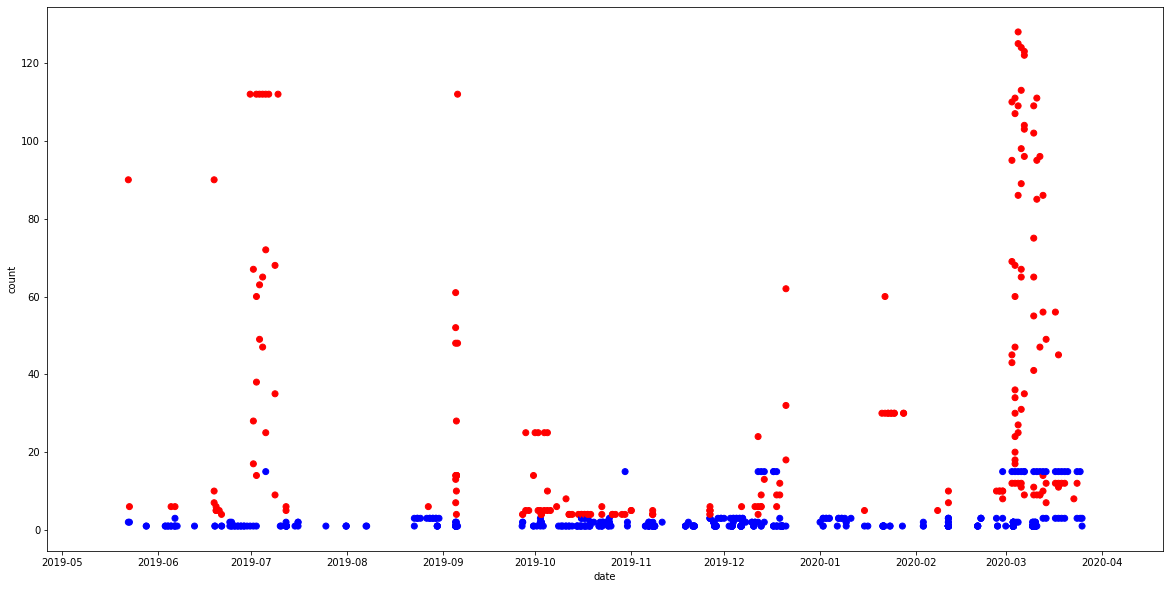

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=('connectgaps = False',
                                                    'connectgaps = True'))
pd.options.mode.chained_assignment = None  # NO WARNING


csv_path = proc_saas_path  
#read csv events data
full_df = pd.read_csv(csv_path, parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x))
#make a copy
df = full_df.copy()
#df['timestamp'] = df['timestamp']
#df['count'] = df['count']

#Isolation Forest implementation with contamination 1%
classifier = IsolationForest(n_estimators=10, max_samples='auto', contamination='auto',\
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42,\
                             verbose=0, behaviour='new')

#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo
classifier.fit(df[['count']])

#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.
df['scores'] = classifier.decision_function(df[[
    'count']])

# predict if a given value is an outlier or not; 1=inliner; -1=outlier
df['anomaly'] = classifier.predict(df[['count']]) 

df.loc[df['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
df.loc[df['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(df['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.scatter(x=df['timestamp'], y=df['count'], color=np.where(df['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()



## Using train test 

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning:

'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.



0    91
1    49
Name: anomaly, dtype: int64


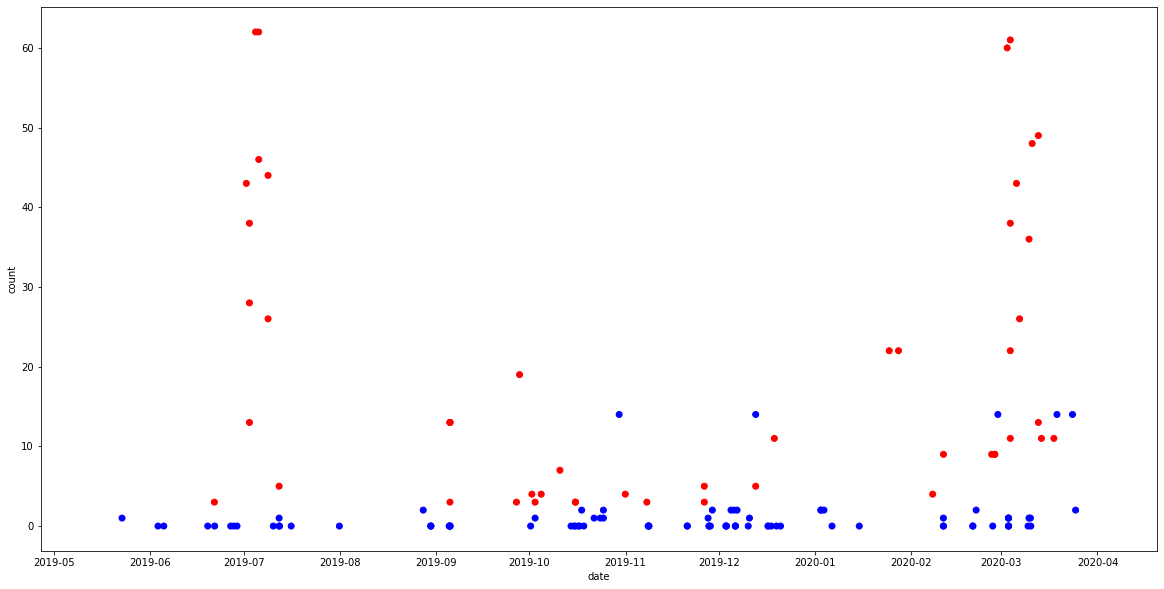

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


fig = make_subplots(rows=2, cols=2, subplot_titles=('connectgaps = False',
                                                    'connectgaps = True'))
pd.options.mode.chained_assignment = None  # NO WARNING


#csv_path = proc_saas_path  
#read csv events data
#full_df = pd.read_csv(csv_path, parse_dates=['timestamp'], date_parser=lambda x: pd.to_datetime(x))
#make a copy
df = new_df.copy()
#df['timestamp'] = df['timestamp']
#df['count'] = df['count']
y_true = df['count'] >60

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(new_df, y_true, test_size=0.2, random_state=42)

#Isolation Forest implementation with contamination 1%
classifier = IsolationForest(n_estimators=10, max_samples='auto', contamination='auto',\
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42,\
                             verbose=0, behaviour='new')

#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo
#classifier.fit(df[['count']])
classifier.fit(X_train[['count']])

#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.
X_train['scores'] = classifier.decision_function(X_train[[
    'count']])

# predict if a given value is an outlier or not; 1=inliner; -1=outlier
X_test['anomaly'] = classifier.predict(X_test[['count']]) 

X_test.loc[X_test['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_test.loc[X_test['anomaly'] == -1, 'anomaly'] = 1

print(X_test['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.scatter(x=X_test.index, y=X_test['count'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()


In [12]:
df['year'] = df['timestamp'].dt.year
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

df['minutes'] = df['timestamp'].dt.minute
# keep the amount of features low and there is not much information necessary from the timestamp.
#In my case it was enough to keep the date as a day-difference from the initial timestamp. 
#This keeps the order and will leave you with only one (ordinal) feature.

#df['time'] = df['year'] * 100000000 +df['month']*1000000 + df['day']* 10000 + df['hour'] *100 + df['minutes']
#df['time']

0      201905221125
1      201905221128
2      201905222002
3      201905222002
4      201905280639
           ...     
692    202003232247
693    202003242247
694    202003242247
695    202003251336
696    202003251336
Name: time, Length: 697, dtype: int64

In [16]:
X = df.iloc[:, [8, 15]].values #count, minutes
y = df.iloc[:, 10].values  # anomaly



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


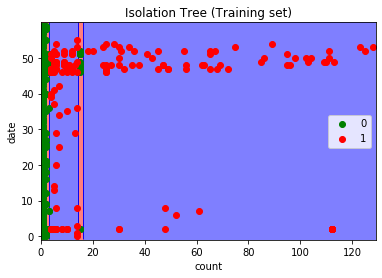

In [17]:
#Visualizing the Training Set results: 
#ListedColormap class help us to colorize the data points
from matplotlib.colors import ListedColormap
#Create local variables X_set and y_set. Because we use these variables again in the test set
X_set, y_set= X_train, y_train
#Create the grid. step=0.01 means all the pixels were actually with #a 0.01 resolution. min and max of the 
#X_Set use with minus ana plus one to prevent ponits to be squeezed #on the axes.

X1,X2 = np.meshgrid(np.arange(start =X_set[:, 0].min() -1, stop=X_set[:, 0].max()+1, step = 0.01),
                    np.arange(start =X_set[:, 1].min() -1, stop=X_set[:, 1].max()+1, step = 0.01))
#Create local variables X_set and y_set
X_set, y_set= X_train, y_train
#Create the grid. step=0.01 means all the pixels were actually with
#a 0.01 resolution. min and max of the 
#X_Set use with minus ana plus one to prevent ponits to be squeezed 
#on the axes.
X1,X2 = np.meshgrid(np.arange(start =X_set[:, 0].min() -1, stop=X_set[:, 0].max()+1, step = 0.01),\
                    np.arange(start =X_set[:, 1].min() -1, stop=X_set[:, 1].max()+1, step = 0.01))
#This is the line applying the classifier on all the pixel #observation points. It colors all the red pixel 
#points and the blue pixel points. contour function make the contour 
#between red and blue regions.
plt.contourf(X1,X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),alpha=0.5,
                     cmap = ListedColormap(('red','blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=ListedColormap(('green', 'red'))(i), label=j)
plt.title('Isolation Tree (Training set)')
plt.xlabel('count')
plt.ylabel('date')
plt.legend()
plt.show()